# SEIRD Model of COVID-19 in Bangladesh 

The objective of this notebook are as follows:
1. Conduct mathematical simulation modeling of COVID-19 cases in <b>Bangladesh</b> based on historical data and project three possible scenarios into the future.
2. Study the effect of social distancing measures on containing the spread of the disease.
3. Derive insights from the data and turn them into actionable measures or policies. 

In [1]:
# Invoking necessary libraries
# ============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.integrate import odeint
!pip install lmfit
import lmfit
!pip install --upgrade covid19dh
from covid19dh import covid19

# Disabling warnings
import warnings
warnings.simplefilter('ignore')

# Create a directory for storing plots
import os
try:
    os.mkdir("figures")
except:
    None

Requirement already up-to-date: covid19dh in c:\users\fahad\.conda\envs\py37\lib\site-packages (2.0.3)


## Importing Data
The primary dataset used in this notebook is that obtained from the <b>COVID-19 Data Repository by the Center for Systems Science and Engineering (CSSE) at John Hoskins University</b>. The secondary data is obtained from the following source:
1. COVID-19 Data Hub API that aggregates information from various reliable sources. Link: https://covid19datahub.io/articles/api/python.html

In [2]:
# Loading and storing data for further work
# =========================================
# Loading necessary datasets
confirmed = pd.read_csv("time_series_covid19_confirmed_global.csv")
confirmed = pd.read_csv("time_series_covid19_confirmed_global.csv")
recovered = pd.read_csv("time_series_covid19_recovered_global.csv")
deaths = pd.read_csv("time_series_covid19_deaths_global.csv")
x, src = covid19("Bangladesh", verbose=False)

# Confirmed cases
df_confirmed = confirmed.loc[confirmed["Country/Region"]=="Bangladesh", "1/22/20":].T
df_confirmed.reset_index(inplace=True)
df_confirmed.rename(columns={20: "cumul", "index": "date"}, inplace=True)
df_confirmed["date"] = pd.to_datetime(df_confirmed.date)
df_confirmed.set_index("date", inplace=True)
df_confirmed["daily"] = (df_confirmed.cumul - \
                         df_confirmed.cumul.shift(1)).fillna(0).astype(int)

# Recovered cases
df_recovered = recovered.loc[recovered["Country/Region"]=="Bangladesh", "1/22/20":].T
df_recovered.reset_index(inplace=True)
df_recovered.rename(columns={20: "cumul", "index": "date"}, inplace=True)
df_recovered["date"] = pd.to_datetime(df_recovered.date)
df_recovered.set_index("date", inplace=True)
df_recovered["daily"] = (df_recovered.cumul - \
                         df_recovered.cumul.shift(1)).fillna(0).astype(int)

# Deaths
df_deaths = deaths.loc[deaths["Country/Region"]=="Bangladesh", "1/22/20":].T
df_deaths.reset_index(inplace=True)
df_deaths.rename(columns={20: "cumul", "index": "date"}, inplace=True)
df_deaths["date"] = pd.to_datetime(df_deaths.date)
df_deaths.set_index("date", inplace=True)
df_deaths["daily"] = (df_deaths.cumul - \
                      df_deaths.cumul.shift(1)).fillna(0).astype(int)

# Policy dataset
df_policy = x[['date', 'school_closing', 'internal_movement_restrictions', 'international_movement_restrictions',
               'workplace_closing', 'transport_closing', 'gatherings_restrictions','cancel_events',
               'stay_home_restrictions']].set_index("date").dropna()

# Combined dataset
df_combined = df_confirmed.join(df_policy, how="outer").dropna()

## Visualizing Data

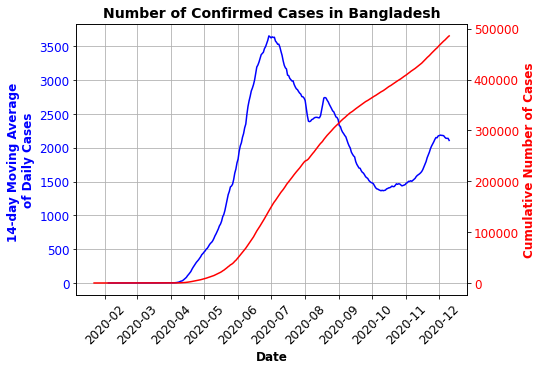

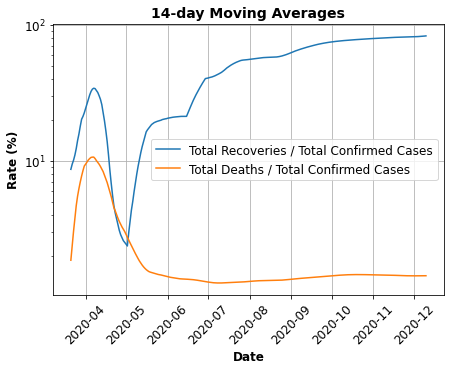

In [3]:
# Plotting Daily New and Cumulative Confirmed Cases
# =================================================
fig, ax1 = plt.subplots(figsize=(7,5))
ax1.plot(df_combined.daily.rolling(window=14).mean(), color="b", label="14-day Moving Average of Daily Confirmed Cases")
plt.xticks(rotation=45, size=12)
plt.xlabel("Date", size=12, fontweight="bold")
plt.ylabel("14-day Moving Average \nof Daily Cases", size=12, color="b", fontweight="bold")
plt.yticks(size=12, color="b")
plt.grid()
ax2 = ax1.twinx()
ax2.plot(df_combined.cumul, color="r", label="Cumulative Confirmed Cases")
plt.yticks(size=12, color="r")
plt.ylabel("Cumulative Number of Cases", size=12, color="r", fontweight="bold")
plt.title("Number of Confirmed Cases in Bangladesh", size=14, fontweight="bold")
plt.savefig("figures/bd_cases_plot.png", bbox_inches="tight")

# Plotting Death and Recovery Rates
# =================================
from scipy.stats.mstats import gmean
recoveryRate = 100*df_recovered.cumul/df_confirmed.cumul
deathRate = 100*df_deaths.cumul/df_confirmed.cumul
# growthRate = 100*((df_confirmed.cumul/df_confirmed.cumul.shift(1))-1)
plt.figure(figsize=(7,5))
plt.plot(recoveryRate.rolling(window=14).mean(), label="Total Recoveries / Total Confirmed Cases")
plt.plot(deathRate.rolling(window=14).mean(), label="Total Deaths / Total Confirmed Cases")
# plt.plot(growthRate.rolling(window=14).apply(lambda x: gmean(1+x)-1), label="Daily Growth of Confirmed Cases (Geometric Mean)")
plt.xticks(rotation=45, size=12)
plt.xlabel("Date", size=12, fontweight="bold")
plt.yticks(size=12)
plt.yscale("log")
plt.ylabel("Rate (%)", size=12, fontweight="bold")
plt.legend(fontsize=12)
plt.title("14-day Moving Averages", size=14, fontweight="bold")
plt.grid()
plt.savefig("figures/bd_recovery_death_plot.png", bbox_inches="tight")

Based on the plots of confirmed cases over time, it is obvious that the curve has not flattened and there will most likely be a second wave of the outbreak. The later part of this study will be looking at one of the social distancing measures implemented by the Bangladesh government to control the spread of the disease. Bangladesh had implemented restrictions on international travel and had closed down schools at a relatively early stage. However, the restrictions on internal movement and the enforcement of those regulations were perhaps not adequate.

In the 14-day moving averages of the death rate shows that it has flattened at around 1.4%. In building our model, we will be using this as the death rate. 

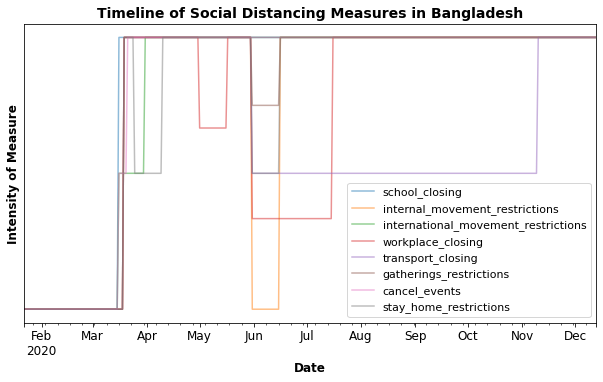

In [4]:
# Plotting the Intensities of Different Social Distancing Measures
# ================================================================
((df_policy-df_policy.min(axis=0))/(df_policy.max(axis=0)-df_policy.min(axis=0))).plot(figsize=(10.25,5.5), alpha=0.5)
plt.xticks(size=12)
plt.xlabel("Date", size=12, fontweight="bold")
plt.legend(fontsize=11)
plt.yticks([])
plt.ylabel("Intensity of Measure", size=12, fontweight="bold")
plt.title("Timeline of Social Distancing Measures in Bangladesh", fontsize=14, fontweight="bold")
plt.savefig("figures/bd_social_dist.png", bbox_inches="tight")

Time between strictest policy enforcement and daily cases reaching a peak in first wave is 105 days.


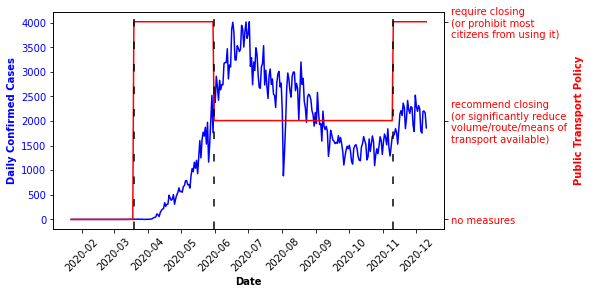

In [5]:
# Plotting Public Transport Closure Policy against Daily New Confirmed Cases
# ==========================================================================
fig, ax1 = plt.subplots(figsize=(7,4))
plt.xticks(rotation=45)
plt.xlabel("Date", fontweight="bold")
plt.ylabel("Daily Confirmed Cases", fontweight="bold", color='b')
plt.yticks(color='b')
ax1.plot(df_combined["daily"], color='b', alpha=1)

ax2 = ax1.twinx()
ax2.plot(df_combined.transport_closing, color='r', alpha=1)
plt.ylabel("Public Transport Policy", fontweight="bold", color='r')
plt.yticks([0,1,2], labels=["no measures", 
                            "recommend closing \n(or significantly reduce \nvolume/route/means of \ntransport available)", 
                            "require closing \n(or prohibit most \ncitizens from using it)"], color='r')
for row in range(1, df_combined.shape[0]):
    if df_combined.iloc[row-1, df_combined.columns.get_loc("transport_closing")]!=df_combined.iloc[row, df_combined.columns.get_loc("transport_closing")]:
        ax2.axvline(x=df_combined.index[row], ymin=df_combined.transport_closing.min(), ymax=df_combined.transport_closing.max(), linestyle=(0, (5,10)), color='k')
plt.savefig("figures/bd_transport_closure.png", bbox_inches="tight")
daysLag = (df_combined.index[np.argmax(df_combined.daily)] - df_combined.index[np.argmax(df_combined.transport_closing)]).days
print("Time between strictest policy enforcement and daily cases reaching a peak in first wave is {} days.".format(daysLag))

For the purpose of this study, we will zoom in on one key social distancing measure "public transport closure". Although international travel was fully restricted, internal movement was not well controlled. According to the news, a key contributor to the spread of the disease was people moving between regions in the country, many of them in public transport. Therefore, this study would look into this factor later on.

## Modelling of COVID-19 Cases (SEIRD Model)
In this section, we would use the SEIRD model to fit our data and make some projections of the daily number of confirmed cases into the future. However, it would be worthwhile to present a basic understanding of the model. 

SEIRD refers to the <b>S</b>usceptible, <b>E</b>xposed, <b>I</b>nfected, <b>R</b>ecovered and <b>D</b>eceased populations. This model involves solving a set of ordinary differential equations as follows.
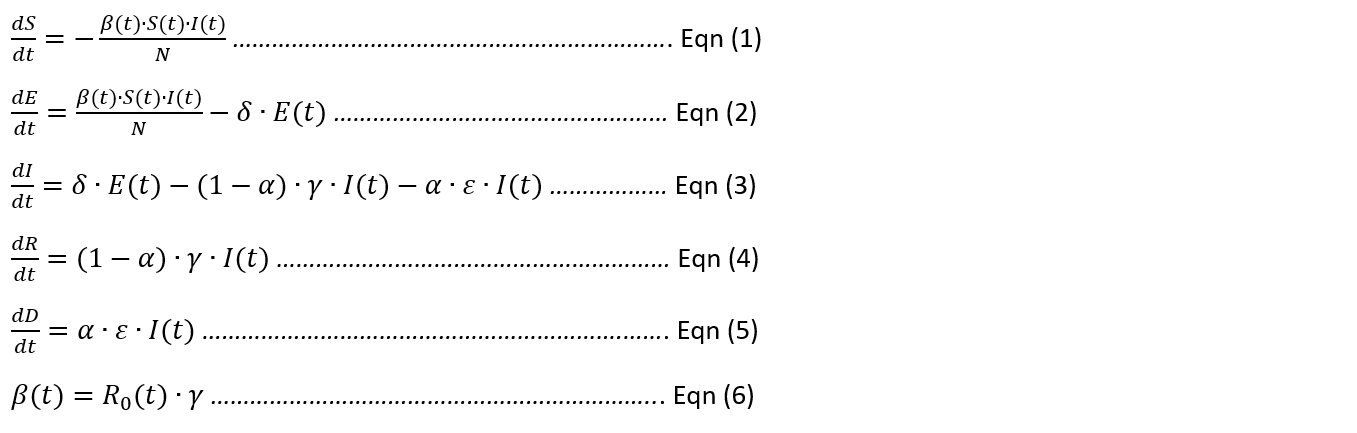

In the SEIRD model, there are five compartments (S, E, I, R and D). People belonging to the total population $N$ of the country move to compartment $S$ first, then $E$ and followed by $I$. From this point, patients either move to compartment $R$ (recovered) or $D$ (deceased).

The term $\beta$ (Eqn 6) is known as the transmission rate (infection producing contacts per unit time). It is the product of $R_{0}$ (the basic reproduction number of the virus) and $\gamma$ (the reciprocal of the mean infectious period of the virus).

Eqn (1) states that the rate of change of the susceptible population (previously unexposed to the pathogen). Unsurprisingly, it is directly related to the current susceptible population, number of people infected and transmission rate.

As shown by Eqn (2), the rate at which exposed population is growing is equal to the net effect of the rate at which the susceptible population is decreasing (as people are moving from compartment $S$ to compartment $E$) and the rate at which people are getting infected (as people are moving from compartment $E$ to $I$).

The rate at which the number of infected people increases is directly proportional to the size of the exposed population. In Eqn (3), $\delta$ is the reciprocal of the mean incubation period of the virus. The product of $\delta$ and $E(t)$ is the rate at which people move from compartment $E$ to compartment $I$. The remaining terms in Eqn (3) account for the removal of people from compartment $I$ to compartments $R$ and $D$.

Given $\alpha$ as the death rate, the rate of change in the recovered population is the product of $(1-\alpha) \cdot I(t)$ and $\gamma$. The term $(1-\alpha) \cdot I(t)$ represents the fraction of the currently infected population that is going to recover while the term $\gamma$, being the reciprocal of mean infectious period, represents how quickly so.

Lastly, Eqn (6) gives us the rate of change of the deceased population. This is simply the product of the reciprocal of the mean time from infection until death $\varepsilon$, and the part of the infected population who will die, $\alpha \cdot I(t)$.

### Modelling of $R_0(t)$ using the logistic function
Intially, the reproduction number $R_0$ is high at the beginning of an outbreak (represented by the upper horizontal asymptote of the logistic function). However, as the daily number of cases reach a peak, the value of $R_0$ comes down and approaches the lower horizontal asymptote of the logistic function. In this model, the lower asymptote is directly related to the effectiveness of social distancing and other containment policies.

Based on the daily confirmed cases data, there is an indication of two distinct waves of the outbreak in Bangladesh.

In [6]:
# Defining Necessary Functions
# ============================

# Derivative Function - Common for waves 1 and 2
def derivative(y, t, N, beta, gamma, delta, alpha, epsilon):
    S, E, I, R, D = y
    dSdt = -beta(t) * S * I / N
    dEdt = beta(t) * S * I / N - delta * E
    dIdt = delta * E - (1 - alpha) * gamma * I - alpha * epsilon * I
    dRdt = (1 - alpha) * gamma * I
    dDdt = alpha * epsilon * I
    return dSdt, dEdt, dIdt, dRdt, dDdt

# Logistic R0 Function - wave 1
def R_0(t, R_0_start, k, x0,R_0_end):
    r0 = (R_0_start-R_0_end) / (1 + np.exp(-k*(-t+x0))) + R_0_end
    return r0

# Model - wave 1
def Model(days, R_0_start, k, x0, R_0_end):
    y0 = S0, E0, I0, R0, D0 # Initial conditions vector
    t = np.linspace(0, days-1, days)
    def beta(t):
        return R_0(t, R_0_start, k, x0, R_0_end) * gamma
    ret = odeint(derivative, y0, t, args=(N, beta, gamma, delta, alpha, epsilon))
    S, E, I, R, D = ret.T
    R_0_over_time = [beta(i)/gamma for i in range(len(t))]
    return t, S, E, I, R, D, R_0_over_time

# Fitter Function for Curve Fitting - wave 1
def fitter(x, R_0_start, k, x0, R_0_end):
    ret = Model(days, R_0_start, k, x0, R_0_end)
    return ret[3][x]

### Modelling Wave 1 of the Pandemic
Since there two waves of the pandemic in Bangladesh, we will model the first wave and use the final conditions of the first wave as the initial conditions of the second wave. Therefore, we start with some assumptions of the initial conditions as follows:
1. Initially, only one person was exposed i.e. $E_0=1$
2. Initially the entire population was susceptible i.e. $S_0=N-E_0=N-1$
3. Initially, nobody was part of the infected, recovered or deceased compatments of the population i.e. $I_0=R_0=D_0=0$

Some key assumptions/facts used in the model are as follows:
1. Total population of Bangladesh is $N=16.1 \times 10^7$
2. Mean infectious period of the virus (in days) during wave 1 is $T_{inf1}=12$
3. Death rate in Bangladesh is $\alpha=1.4$%
4. Incubation period of the virus ranges from 5 to 6 days i.e. $T_{inc}=mean(5,6)$
5. Average time between infection and death (in days) is $T_{death}=9$
6. Based on the data visualization earlier, the start of wave 2 of pandemic occurs on 02-10-2020

<b>How is the end of a wave marked?</b>

The end of a wave of the pandemic is considered to be the point in time when the daily number of confirmed cases reaches a maximum. Alternatively, it is also the time when the curve for the cumulative number of cases start to flatten.

In [7]:
# Conditions for Wave 1 of Pandemic
N = 16.1e7
T_inf = 12.0
T_inc = np.mean([5,6])
T_death = 9.0
startPhase2 = "2020-10-02"

# Model Constraints (wave 1)
gamma = 1 / T_inf
delta = 1 / T_inc
alpha = 1.4 / 100
epsilon = 1 / T_death
split = np.where(df_combined.index==startPhase2)[0][0]

# Model Initial Conditions (wave 1)
S0, E0, I0, R0, D0 = N-1.0, 1.0, 0.0, 0.0, 0.0

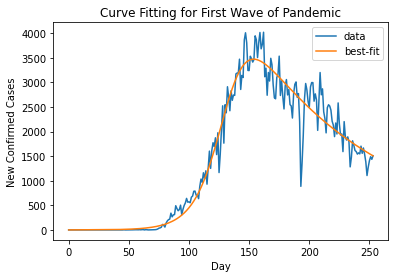

Optimum parameter settings:
{'R_0_start': 2.537792670768846, 'k': 0.1040425682971074, 'x0': 127.76865018707579, 'R_0_end': 0.8453293607531785}


In [8]:
# Parameter Grid for Model
params_init_min_max = {"R_0_start": (1, 2.0, 5.0), "k": (0.2, 0.01, 5.0), 
                       "x0": (50, 0, 130), "R_0_end": (2, 0.3, 3.5)}

# X and Y Variables
data = df_combined.daily.values.flatten()[:split]
days = len(data)
y_data = data
x_data = np.linspace(0, days - 1, days, dtype=int)

# Fitting Curve
mod = lmfit.Model(fitter)

for kwarg, (init, mini, maxi) in params_init_min_max.items():
    mod.set_param_hint(str(kwarg), value=init, min=mini, max=maxi, vary=True)

params = mod.make_params()
results = mod.fit(y_data, params, method="least_squares", x=x_data)
results.plot_fit(datafmt="-")
plt.title("Curve Fitting for First Wave of Pandemic")
plt.xlabel("Day")
plt.ylabel("New Confirmed Cases")
plt.show()

fittedParams = results.best_values
fit1=Model(days, R_0_start=fittedParams["R_0_start"], k=fittedParams["k"], x0=fittedParams["x0"],
               R_0_end=fittedParams["R_0_end"])
print("Optimum parameter settings:")
print(fittedParams)

# Store Values for Plotting
t1, S1, E1, I1, R1, D1, Ro1 = fit1[0], fit1[1], fit1[2], fit1[3], fit1[4], fit1[5], fit1[6]

### Modelling Wave 2 of the Pandemic
In wave 2, the initial conditions will be the final conditions of wave 1. This model will be extended to forecast future cases. The forecast will look at three scenarios, namely the best case, the worst case and the middle ground. In this model, two variables are considered ($R_0$ and $T_{inf}$) for forecasting. If the social distancing and other containment measures are successful, $R_0$ will be expected to decrease. On the other hand, development of herd immunity, better treatment facilities and administration of effective vaccines could reduce the infectious period $T_{inf}$. In all the cases, it is assumed that it will take 105 days for the policies to take effect (according to the data from the first wave).
1. <b>Best case scenario:</b> Social distancing and containment policies in wave 2 are 10% more effective in reducing the final reproduction number than in wave 1 ($\rho = 0.10$). There is also a 5% drop in the mean infectious period ($\zeta = -0.05$).
2. <b>Worst case scenario:</b> Social distancing policies are 10% less effective probably due to poor enforcement, raising the final reportuction number of wave 2 above that of wave 1 ($\rho = -0.10$). The mean infectious period remains unchanged ($\zeta = 0$).
3. <b>Middle ground:</b> Social distancing measures are 5% less effective as those implemented in wave 1 ($\rho = -0.05$). The mean infectious period drops by 2.5% due to better equipped hospitals, treatments, vaccination programs and herd immunity ($\zeta = -0.025$). 

<b>How does the value of $\rho$ affect the model?</b>

The value of $\rho$ determines the relative effectiveness of social distancing and other containment measures implemented by the government. A value of 0 signifies that the effectiveness of the measures in controlling the spread of the virus is the same as that in wave 1. A simplification assumption is used here as as follows: $R_0[final, wave 2]=(1/(1+\rho)) \times R_0[final, wave 1]$. Therefore, a value of $\rho$ above zero in wave 2 means the final reproduction number in wave 2 will be lower than that of wave 1.

<b>How does the value of $\zeta$ affect the model?</b>

The value of $\zeta$ represents any effect on the length of the mean infectious period of the virus. The mean infectious period in wave 1 was $T_{inf} = 12$ days. However, in phase 2, $T_{inf, wave 2}=(1+\zeta) \times T_{inf, wave 1}$. This means that, if for reasons such as herd immunity development, better treatment or even effective vaccines, the mean infectious period drops in wave 2, it is represented by $\zeta<0$ and vice versa. 

In [9]:
# Define a Function to Fit Curve with Specified Parameters (wave 2)
def fitCurvePhase2(zeta, rho, forecastDays, t_change=50, case="default"):
    # Logistic R0 Function - wave 2
    def R_0_2(t, R_0_start, k, x0, R_0_end):
        r0 = (R_0_start-R_0_end) / (1 + np.exp(-k*(-t+x0))) + R_0_end
        if t<=days:
            return r0
        else:
            R_0_end2 = (1/(1+rho))*R_0_start2
            r0_2 = (R_0_end-R_0_end2) / (1 + np.exp(-k*(-t+x0+days+t_change))) + R_0_end2
            return r0_2
    
    # Computing gamma (wave 2)
    gamma_2 = 1 / ((1+zeta)*T_inf)
    
    # Model - wave 2
    def Model_2(days, k, x0, R_0_start, R_0_end):
        y0 = S0_2, E0_2, I0_2, R0_2, D0_2 # Initial conditions vector (same as final conditions of wave 1)
        t = np.linspace(0, days-1, days)
        def beta(t):
            return R_0_2(t, k, x0, R_0_start, R_0_end) * gamma_2
        ret = odeint(derivative, y0, t, args=(N, beta, gamma_2, delta, alpha, epsilon))
        S, E, I, R, D = ret.T
        R_0_over_time = [beta(i)/gamma_2 for i in range(len(t))]
        return t, S, E, I, R, D, R_0_over_time
    
    # Fitter Function for Curve Fitting - wave 2
    def fitter_2(x, R_0_start, k, x0, R_0_end):
        ret = Model_2(days, R_0_start, k, x0, R_0_end)
        return ret[3][x]
    
    # Parameter Grid for Model
    params_init_min_max = {"k": (0.01, -10, 20), "x0": (60, 0, 200), "R_0_end": (1.2, 0.3, 3.5),
                           "R_0_start": (0.9, R_0_start2, 3.0)}

    # X and Y Variables
    data = df_combined.daily.values.flatten()[split:] 
    days = len(data)
    y_data = data
    x_data = np.linspace(0, days - 1, days, dtype=int)

    # Curve Fitting
    mod2 = lmfit.Model(fitter_2)

    for kwarg, (init, mini, maxi) in params_init_min_max.items():
        mod2.set_param_hint(str(kwarg), value=init, min=mini, max=maxi, vary=True)

    params2 = mod2.make_params()
    results2 = mod2.fit(y_data, params2, method="least_squares", x=x_data)
    plt.figure()
    results2.plot_fit(datafmt="-")
    plt.title("Curve Fitting for Wave 2 of Pandemic"+" ("+case+")")
    plt.xlabel("Day")
    plt.ylabel("New Confirmed Cases")
    plt.show()

    fittedParams2 = results2.best_values
    print("Optimum Parameter Settings:")
    print(fittedParams2)
    fit2=Model_2(days+forecastDays, k=fittedParams2["k"], x0=fittedParams2["x0"], R_0_end=fittedParams2["R_0_end"],
               R_0_start=fittedParams2["R_0_start"])

    # Storing Values for Plotting
    t2, S2, E2, I2, R2, D2, Ro2 = fit2[0]+split, fit2[1], fit2[2], fit2[3], fit2[4], fit2[5], fit2[6]
    S2[0], E2[0], I2[0], D2[0], Ro2[0] = S1[-1], E1[-1], I1[-1], D1[-1], Ro1[-1]
    
    # Return Values
    return {"t": t2, "S": S2, "E": E2, "I": I2, "R": R2, "D": D2, "Ro": Ro2}

In [10]:
# Parameters for wave 2 of Pandemic
forecastDays = 365
t_change = 70 # Time lag (in days) for measures to take effect on R_0
zeta_worst = 0/100
zeta_best = -5/100
zeta_mid = -2.5/100
rho_worst = -10/100
rho_best = 10/100
rho_mid = -5/100

# Model Initial Conditions (Wave 2)
S0_2 = fit1[1][-1]
E0_2 = fit1[2][-1]
I0_2 = fit1[3][-1]
R0_2 = fit1[4][-1]
D0_2 = fit1[5][-1]
R_0_start2 = Ro1[-1]

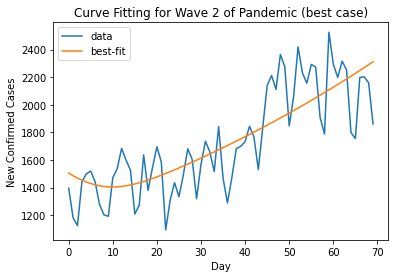

Optimum Parameter Settings:
{'R_0_start': 0.8453331032381431, 'k': 0.3352783735227287, 'x0': 6.301087517135482, 'R_0_end': 1.1653506678500978}


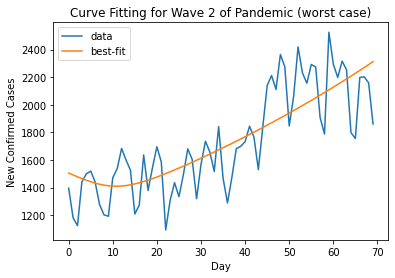

Optimum Parameter Settings:
{'R_0_start': 0.8453330781458375, 'k': 0.40067142159198216, 'x0': 7.492888245274997, 'R_0_end': 1.172450989309157}


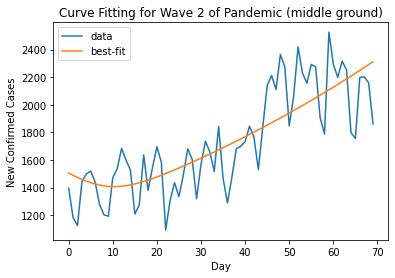

Optimum Parameter Settings:
{'R_0_start': 0.8453345090586569, 'k': 0.36784640421530906, 'x0': 6.927097991231952, 'R_0_end': 1.1688896416254397}


In [11]:
# Fitting the Curve for three Scenarios
# =====================================
# The Best Case
bestCase = fitCurvePhase2(zeta_best, rho_best, forecastDays, t_change=t_change, case="best case")

# The Worst Case
worstCase = fitCurvePhase2(zeta_worst, rho_worst, forecastDays, t_change=t_change, case="worst case")

# The Middle Ground
midCase = fitCurvePhase2(zeta_mid, rho_mid, forecastDays, t_change=t_change, case="middle ground")

As we can see above, the curve fits reasonably well with the existing data for all the three scenarios of wave 2 modelled.

End of Second Wave is on 2021-02-23.
Date of enforcement of latest transport closure was 2020-11-10.
Time between enforcement of latest measures and next peak in daily cases is 105 days.


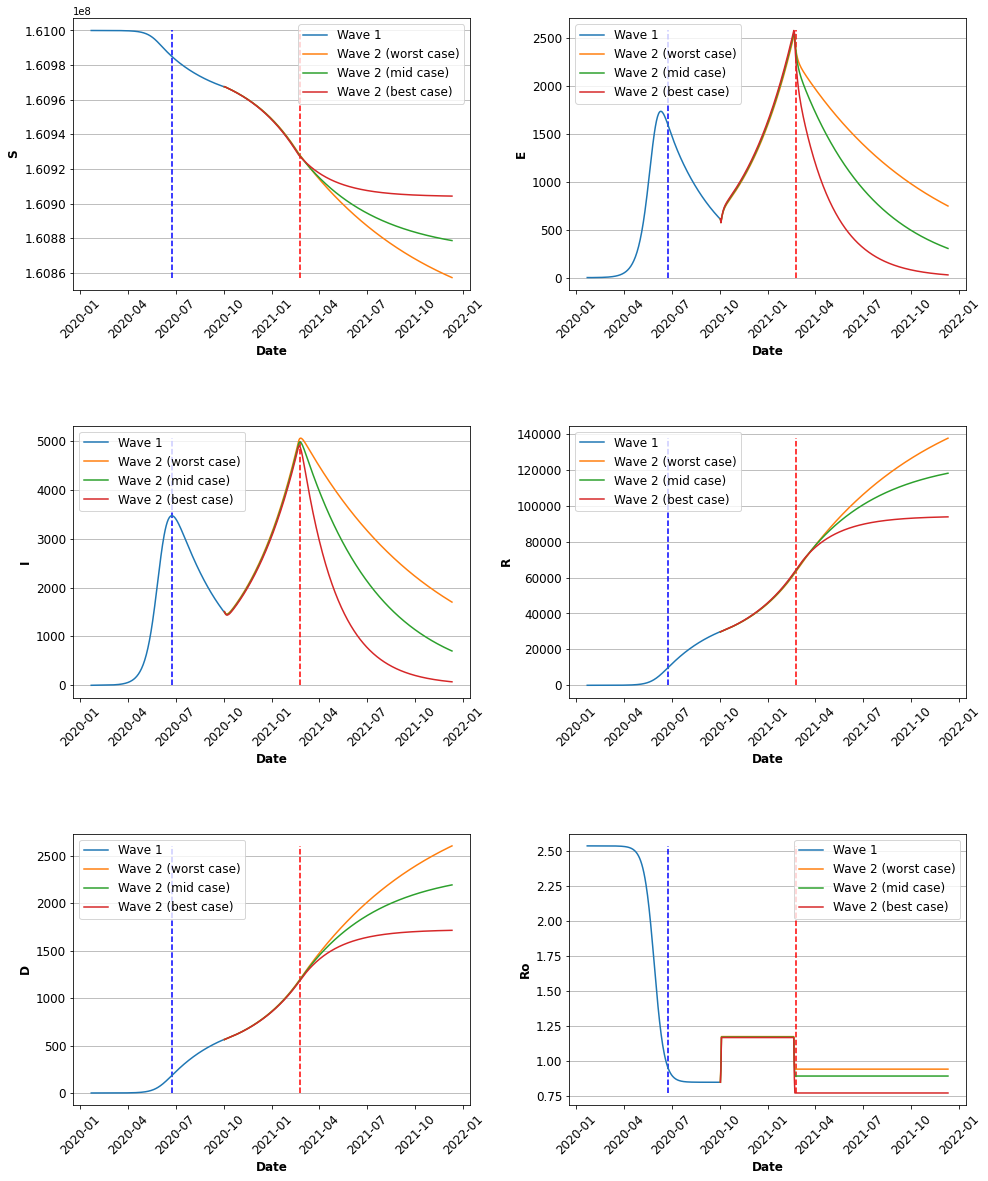

In [12]:
import datetime as dt

cases = {}

n=0
caseKeys = ["worst", "mid", "best"]
for case in [worstCase, midCase, bestCase]:
    t_ = np.arange(0.0, split).tolist() + case["t"].tolist()
    t_ = [df_combined.index[0]+dt.timedelta(days=t) for t in t_]
    S_ = S1.tolist() + case["S"].tolist()
    E_ = E1.tolist() + case["E"].tolist()
    I_ = I1.tolist() + case["I"].tolist()
    R_ = R1.tolist() + case["R"].tolist()
    D_ = D1.tolist() + case["D"].tolist()
    Ro_ = Ro1 + case["Ro"]
    cases[caseKeys[n]] = {"t": t_, "S": S_, "E": E_, "I": I_, "R": R_, "D": D_, "Ro": Ro_}
    n += 1
    
plt.figure(figsize=(16,20))

plotCount = 1
variables = ["S", "E", "I", "R", "D", "Ro"]
for var in variables:
    plt.subplot(3,2,plotCount)
    plt.grid(axis="y")
    plt.subplots_adjust(wspace=0.25, hspace=0.5)
    plt.plot(cases["mid"]["t"][:split], cases["mid"][var][:split], label="Wave 1")
    for case in cases:
        plt.plot(cases[case]["t"][split:], cases[case][var][split:], label= "Wave 2 ("+case+" case)")
    plt.legend(fontsize=12)
    plotCount += 1
    plt.xlabel("Date", size=12, fontweight="bold")
    plt.xticks(rotation=45, size=12)
    plt.ylabel(var, size=12, fontweight="bold")
    plt.yticks(size=12)
    minimum = min(min(cases["worst"][var]), min(cases["mid"][var]), min(cases["best"][var]))
    maximum = max(max(cases["worst"][var]), max(cases["mid"][var]), max(cases["best"][var]))
    peakPhase1 = cases["mid"]["t"][:split][np.argmax(cases["mid"]["I"][:split])]
    endPhase2 = cases["mid"]["t"][np.argmax(cases["mid"]["I"])]
    plt.vlines(x=peakPhase1, ymin=minimum, ymax=maximum, linestyle="dashed", color='b')
    plt.vlines(x=endPhase2, ymin=minimum, ymax=maximum, linestyle="dashed", color='r')
plt.savefig("figures/model_three_cases.png", bbox_inches="tight")

print("End of Second Wave is on {}.".format(dt.datetime.date(endPhase2)))
enforceDate = df_combined.loc[startPhase2:].index[np.argmax(df_combined.loc[startPhase2:, "transport_closing"])]
timeLag = (endPhase2 - enforceDate).days
print("Date of enforcement of latest transport closure was {}.".format(dt.datetime.date(enforceDate)))
print("Time between enforcement of latest measures and next peak in daily cases is {} days.".format(timeLag))

In the model for wave 2, the peak in the daily number of new confirmed cases occurs 105 days after the transport restrictions are implemented. This time lag was derived from existing data for wave 1 where the peak occured exactly 105 days after the transport restrictions were implemented at the strictest level. Also, the effect of the containment measures significant in reducing the reproduction number to below 1. However, there is a spike in $R_0$ in wave 2 which will need to be controlled accordingly.

In all the scenarios studied, there is reason to hope for the number of cases to begin to plateau from 23 February 2021 onwards.

Let us now plot the cumulative number of confirmed cases for the three different scenarios.

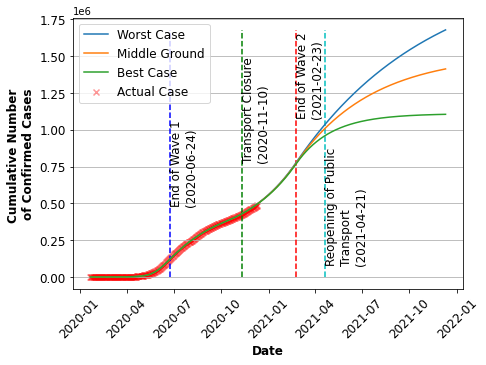

In [13]:
import datetime as dt

df_worst = pd.DataFrame(cases["worst"]).set_index("t")
df_worst["cumul_I"] = df_worst.I.cumsum()

df_mid = pd.DataFrame(cases["mid"]).set_index("t")
df_mid["cumul_I"] = df_mid.I.cumsum()

df_best = pd.DataFrame(cases["best"]).set_index("t")
df_best["cumul_I"] = df_best.I.cumsum()

plt.figure(figsize=(7,5))
plt.plot(df_worst.index, df_worst.cumul_I, label="Worst Case")
plt.plot(df_mid.index, df_mid.cumul_I, label="Middle Ground")
plt.plot(df_best.index, df_best.cumul_I, label="Best Case")
plt.scatter(df_combined.index, df_combined.cumul, label="Actual Case", color='r', marker="x", alpha=0.4)

minimum = df_best.cumul_I.min()
maximum = df_worst.cumul_I.max()
plt.vlines(x=peakPhase1, ymin=minimum, ymax=maximum, linestyle="dashed", color='b')
plt.vlines(x=endPhase2, ymin=minimum, ymax=maximum, linestyle="dashed", color='r')
plt.vlines(x=enforceDate, ymin=minimum, ymax=maximum, linestyle="dashed", color='g')

midCase = pd.DataFrame(cases["mid"]).set_index("t")
firstPeak = midCase.loc[peakPhase1, "I"]
midCase = midCase.loc[midCase.index>endPhase2, ["I"]]
endQuarantine = midCase.loc[midCase.I<=firstPeak].index[0]
plt.vlines(x=endQuarantine, ymin=minimum, ymax=maximum, linestyle="dashed", color='c')

plt.xticks(rotation=45, size=12)
plt.yticks(size=12)
plt.xlabel("Date", size=12, fontweight="bold")
plt.ylabel("Cumulative Number \nof Confirmed Cases", size=12, fontweight="bold")
plt.legend(fontsize=12)
plt.grid(axis="y")
plt.text(peakPhase1, 0.5e6, "End of Wave 1\n({})".format(dt.datetime.date(peakPhase1)), size=12, rotation=90)
plt.text(endPhase2, 1.1e6, "End of Wave 2\n({})".format(dt.datetime.date(endPhase2)), size=12, rotation=90)
plt.text(enforceDate, 0.8e6, "Transport Closure\n({})".format(dt.datetime.date(enforceDate)), size=12, rotation=90)
plt.text(endQuarantine, 0.1e6, "Reopening of Public \nTransport\n({})".format(dt.datetime.date(endQuarantine)), size=12, rotation=90)
plt.savefig("figures/cumul_I_three_cases.png", bbox_inches="tight")

## Policy Advice

Looking at the figure for wave 1, one can observe that the restrictions on transport were lifted prematurely (before the number of cases peaked). Also, internal movement restrictions were significantly relaxed at the same time. These inevitably led to a second wave with a steeper spike. In the model for wave 1, we can see that the containment measures taken by the government were effective in reducing $R_0$ and flattening the curve. Our goal is to flatten the curve for wave 2 and ensure there is no wave 3.

From the model and analysis of the data, it is recommended to enforce the local transport restrictions at the strictest level (which is currently in place) till at least the end of the second wave (23 February 2021). In addition, other internal movement restrictions should also be put in place till the aforementioned date. These measures will likely prevent a third wave of spike in daily number of confirmed cases.

Since we are expecting a higher peak in the number of daily cases, it would be prudent to restrict internal movement (especially through closure of public transport), if possible, until the number of cases return to the previous peak of wave 1 (which would be in <b>March of 2021</b> according to the middle-ground model).